First step is to import required libraries and utilities.

In [1]:
# -*- coding: utf-8 -*-
import json # For reading COCO annotations file
import cv2   # For image loading and manipulation
import numpy as np  # For numerical and array operations

from matplotlib import pyplot as plt   # For visualizing images

import os  # For file system access
from ultralytics import YOLO  # Model to train

### STEP I: Visualize Images

First, I set the path to the annotations file. Then I load the file using __json__ library, after which I specifically extract the specific information for the images and their respective annotations.

In [2]:
def return_split_files(split, dataset_folder = "segmentation_dataset", images = True):
    # Path to corresponding COCO annotations file
    if split == "test":
        ANN_PATH = "../extras/extra_coco_annotations.json"
    else:
        ANN_PATH = "../extras/coco_annotations.json"

    # Load annotations file
    file = json.load(open(ANN_PATH, "r"))

    ftype = "images" if images else "labels"
    
    image_base_dir = f"../datasets/{dataset_folder}/{ftype}/{split}"
    image_paths = [os.path.join(image_base_dir, f) for f in os.listdir(image_base_dir)]
    return image_paths

TEST_IMAGE_PATHS = return_split_files("test", "stenosis_dataset", True)
TEST_LABEL_PATHS = return_split_files("test", "stenosis_dataset", False)

### STEP II: Model Training

Now, I train the model. To do this, I need to ensure that the results are repproducible. I also need a configuration file telling the model where to find the data, and what labels to expect in the data.

In [3]:
import torch

In [4]:
# Ensure reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# Instantiate model
model = YOLO('yolov8s.pt')

In [6]:
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [7]:
# Load configuration file
CONFIG_FILE = os.path.join("..", "config", "stenosis_config.yaml")

In [8]:
# Set image size for training
ORIGINAL_IMGSZ = (694, 542)
# IMGSZ = 672
IMGSZ = 640
freeze = None
dropout = .4

In [9]:
# Set folder for artefact storage
folder = "stenosis_yolov8s_dropout"

In [10]:
# Train model
results = model.train(
    data = CONFIG_FILE,
    visualize = True,
    epochs = 150,
    imgsz = IMGSZ,
    optimizer = "Adam",
    lr0 = 1e-3,
    batch = -1,
    pretrained = True,
    freeze = freeze,
    save = True,
    cos_lr = True,
    deterministic = True,
    dropout = dropout,
    name = folder
)

Ultralytics YOLOv8.2.0 🚀 Python-3.9.18 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=../config/stenosis_config.yaml, epochs=150, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=stenosis_yolov8s_dropout, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.4, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=True, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, 

/home/harkhymadhe/miniforge3/envs/mri/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025831482/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU) 8.00G total, 0.26G reserved, 0.13G allocated, 7.62G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11137148       28.65         0.491         22.64         65.75        (1, 3, 640, 640)                    list
    11137148       57.31         0.694          19.5         35.79        (2, 3, 640, 640)                    list
    11137148       114.6         1.206         26.07         37.12        (4, 3, 640, 640)                    list
    11137148       229.2         1.988         31.87         43.74        (8, 3, 640, 640)                    list
    11137148       458.5         3.567         59.38         63.96       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 20 for CUDA:0 4.79G/8.00G (60%) ✅


train: Scanning /mnt/c/Users/Harkhymadhe/Desktop/source/export_3/SpineMRI/datasets/stenosis_dataset/labels/train.cache... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]
val: Scanning /mnt/c/Users/Harkhymadhe/Desktop/source/export_3/SpineMRI/datasets/stenosis_dataset/labels/val.cache... 35 images, 0 backgrounds, 0 corrupt: 100%|██████████| 35/35 [00:00<?, ?it/s]


Plotting labels to runs/detect/stenosis_yolov8s_dropout/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046875), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/stenosis_yolov8s_dropout
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      5.05G      5.781      28.11      3.557         20        640: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all         35        239          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      5.08G      4.535      21.31      2.664          6        640: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         35        239          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      5.04G      4.502      26.13      2.612         22        640: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         35        239          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      5.18G      4.401       8.16      2.099         11        640: 100%|██████████| 4/4 [00:00<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all         35        239       0.77       0.05     0.0131    0.00306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      5.16G      2.617      3.556      1.063          0        640: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         35        239    0.00387     0.0708     0.0032   0.000821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      5.15G       3.08      3.475      1.219          4        640: 100%|██████████| 4/4 [00:00<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         35        239     0.0328       0.16     0.0237    0.00732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      5.17G      2.142      2.639     0.8697          0        640: 100%|██████████| 4/4 [00:00<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         35        239      0.537      0.103      0.021    0.00557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      5.17G      2.686      2.718      1.173          7        640: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         35        239      0.532      0.114     0.0305    0.00718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      5.16G      2.899       2.78      1.317          6        640: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         35        239      0.567      0.199     0.0658     0.0162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      5.17G      2.547      2.448      1.013         24        640: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         35        239      0.287      0.223     0.0643     0.0209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      5.17G      2.578      2.387      1.094         19        640: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         35        239       0.33      0.148     0.0662     0.0167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      5.19G      2.464      2.214      1.036         20        640: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         35        239      0.329      0.161     0.0616     0.0189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      5.18G      2.375      2.238      1.106          5        640: 100%|██████████| 4/4 [00:00<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         35        239      0.597      0.254      0.182     0.0496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      5.19G      2.358      1.985      1.047         18        640: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         35        239      0.196      0.321      0.212      0.075



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      5.16G      2.471      1.799      1.064         14        640: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         35        239      0.216      0.263      0.209     0.0766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      5.18G      2.259      1.744      1.056          6        640: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         35        239       0.45       0.23      0.173     0.0595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      5.16G      2.445      1.913      1.088         10        640: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all         35        239      0.423      0.259      0.135      0.047



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      5.18G      2.299       1.92      1.068          8        640: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all         35        239      0.692      0.202      0.186     0.0705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      5.18G      2.242      1.729      1.013         19        640: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         35        239       0.71      0.216      0.208     0.0764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150       5.2G      2.215      1.719     0.9549         27        640: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         35        239      0.475      0.423      0.248      0.078



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      5.22G      2.266      1.768     0.9675         16        640: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         35        239      0.484      0.424      0.316      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      5.15G      2.071      1.571      1.029         10        640: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all         35        239      0.522      0.439      0.323      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150       5.2G      2.091      1.644      1.013          7        640: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         35        239      0.494      0.435      0.272     0.0986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      5.18G      2.051      1.574     0.9859          5        640: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         35        239      0.481      0.306      0.219     0.0788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      5.13G      2.052      1.547      1.018         10        640: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         35        239      0.523      0.381      0.267     0.0931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      5.19G      2.099      1.602     0.9524         16        640: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         35        239      0.489      0.374       0.24     0.0862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      5.18G      1.973      1.521      0.958         13        640: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all         35        239      0.514      0.321      0.219     0.0748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      5.14G      1.983      1.466     0.9753          7        640: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         35        239      0.537      0.327      0.255     0.0803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      5.17G      2.241      1.633     0.9816         17        640: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         35        239      0.719      0.229      0.257     0.0901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      5.17G      2.021      1.865      1.103          6        640: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

                   all         35        239      0.599      0.351      0.284     0.0955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      5.16G      1.884      1.518     0.9401          6        640: 100%|██████████| 4/4 [00:00<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         35        239      0.557      0.317      0.288      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      5.21G      2.037       1.57     0.9996          6        640: 100%|██████████| 4/4 [00:00<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         35        239      0.471      0.356      0.278      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      5.19G      2.018      1.694      1.034         10        640: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         35        239      0.452      0.237      0.184     0.0663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      5.16G      2.095      1.637     0.9631         21        640: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         35        239      0.468       0.27      0.184     0.0675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      5.15G      1.956      1.442     0.9905          8        640: 100%|██████████| 4/4 [00:00<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         35        239        0.5      0.353      0.199     0.0807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      5.21G      1.515       1.34     0.7278          0        640: 100%|██████████| 4/4 [00:00<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         35        239       0.46      0.407      0.213     0.0788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      5.16G      2.031      1.433     0.9688          8        640: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         35        239       0.47      0.393      0.235     0.0845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      5.22G      1.921      1.578      1.007          7        640: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         35        239      0.489      0.446      0.236     0.0831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      5.17G       2.01      1.449     0.9609         22        640: 100%|██████████| 4/4 [00:00<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         35        239      0.441      0.233      0.139     0.0507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      5.18G      1.884      1.356      0.937         12        640: 100%|██████████| 4/4 [00:00<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         35        239      0.494      0.398      0.187      0.063



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      5.22G      1.811      1.406     0.9581          8        640: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

                   all         35        239      0.501      0.438      0.283      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      5.18G      1.776      1.366     0.9314         10        640: 100%|██████████| 4/4 [00:00<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         35        239       0.56      0.324      0.293      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      5.15G      1.851      1.369     0.9533          5        640: 100%|██████████| 4/4 [00:00<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         35        239      0.562      0.342      0.276     0.0958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      5.18G      1.878      1.388     0.9475         16        640: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

                   all         35        239      0.537      0.375      0.278     0.0971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      5.18G       2.02      1.497     0.9483         24        640: 100%|██████████| 4/4 [00:00<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all         35        239      0.516      0.368      0.272      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      5.13G        1.9      1.688     0.9101          1        640: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         35        239      0.502      0.375      0.232      0.085



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      5.18G      2.156      1.595      1.023          6        640: 100%|██████████| 4/4 [00:00<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

                   all         35        239      0.468      0.306      0.183     0.0641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      5.18G      1.878      1.282     0.9189          7        640: 100%|██████████| 4/4 [00:00<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all         35        239      0.539      0.369      0.263        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      5.16G      2.107        1.4     0.9269         25        640: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         35        239      0.583      0.413      0.286      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      5.18G      1.406      1.894     0.7237          0        640: 100%|██████████| 4/4 [00:00<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         35        239      0.598      0.375      0.298      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      5.17G      1.867      1.441     0.9398         15        640: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all         35        239      0.536       0.29      0.274     0.0945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      5.16G      1.877      1.344     0.9151         20        640: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         35        239       0.54      0.317      0.298      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      5.18G      1.836       1.38     0.9296         13        640: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         35        239      0.791      0.257      0.304       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150       5.2G      1.807      1.329     0.9434          7        640: 100%|██████████| 4/4 [00:00<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         35        239      0.608      0.312      0.344      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      5.19G      1.338      1.252     0.7001          0        640: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         35        239      0.623      0.306      0.334      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      5.19G      1.951      1.365     0.9378          6        640: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         35        239      0.687      0.304      0.319      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      5.18G      1.904      1.438      1.052          7        640: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         35        239      0.642      0.298      0.321       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      5.16G      1.822      1.225      0.923         24        640: 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all         35        239      0.553      0.336       0.32      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      5.19G       1.67      1.264     0.9077          6        640: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         35        239      0.551      0.332      0.298      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      5.21G      1.685      1.277     0.8872         21        640: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         35        239      0.527      0.271      0.268      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150       5.2G      1.726      1.155     0.8947         26        640: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         35        239      0.642      0.278      0.295      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      5.19G      1.695      1.192     0.8948         17        640: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         35        239      0.594      0.277      0.307      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      5.22G      1.645      1.139     0.9102         11        640: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         35        239       0.54      0.269      0.294      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      5.14G       1.65       1.21     0.9242          8        640: 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         35        239      0.593      0.246      0.296      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150       5.2G      1.654      1.142     0.8931         26        640: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         35        239      0.544      0.242      0.291       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      5.18G      1.526       1.11     0.9102          5        640: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         35        239      0.541      0.232      0.287      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      5.15G      1.698      1.233     0.9341          7        640: 100%|██████████| 4/4 [00:00<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all         35        239      0.564      0.214      0.285      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      5.21G       1.18      1.076     0.6662          0        640: 100%|██████████| 4/4 [00:00<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all         35        239      0.544      0.225      0.285      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      5.19G      1.634      1.084     0.9037          5        640: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         35        239      0.461      0.334      0.304      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      5.16G       1.68       1.17     0.9051         23        640: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         35        239      0.529        0.3      0.313      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150       5.2G      1.822      1.112     0.9074         13        640: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         35        239      0.534      0.316      0.329      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      5.21G       1.68      1.206     0.8928         17        640: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         35        239      0.559      0.369      0.324      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      5.12G      1.774      1.347     0.9767          3        640: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         35        239      0.591      0.397      0.345      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      5.17G      1.625      1.047     0.9245          7        640: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all         35        239      0.577      0.405      0.345      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      5.18G      1.612      1.033     0.9218          6        640: 100%|██████████| 4/4 [00:00<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         35        239       0.56      0.343      0.327      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      5.13G      1.173     0.9483     0.6777          0        640: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         35        239      0.838      0.301      0.354      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      5.17G      1.561      1.071     0.9293          8        640: 100%|██████████| 4/4 [00:00<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         35        239      0.823      0.291      0.351      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      5.21G      1.589      1.071     0.8789         10        640: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         35        239      0.794      0.307      0.331      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      5.17G      1.518      1.023     0.8858          7        640: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         35        239      0.594      0.357      0.319       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      5.19G      1.512      1.055     0.8767         14        640: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         35        239      0.582      0.354      0.308      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      5.19G      1.673      1.121     0.8612          8        640: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         35        239      0.588      0.386      0.333      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      5.18G      1.566      1.167     0.9587          5        640: 100%|██████████| 4/4 [00:00<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         35        239      0.791      0.308      0.329      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      5.18G      1.126     0.9547     0.6633          0        640: 100%|██████████| 4/4 [00:00<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         35        239      0.787      0.297      0.328      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      5.18G      1.648     0.9929     0.8867         13        640: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         35        239      0.795      0.312       0.34      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      5.15G      1.491      1.063     0.9059         11        640: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         35        239      0.801      0.318      0.356      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      5.18G      1.617      1.048     0.9334          6        640: 100%|██████████| 4/4 [00:00<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         35        239      0.577      0.385      0.342      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      5.19G      1.141     0.8028     0.6708          0        640: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         35        239      0.594      0.387      0.329      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      5.18G      1.573      1.028     0.8823         23        640: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all         35        239      0.601      0.365      0.325      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150       5.2G      1.457     0.9422     0.8711          9        640: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         35        239      0.634       0.35      0.337      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      5.18G      1.484       1.04     0.8868          8        640: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         35        239      0.636      0.368      0.367      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      5.16G      1.554     0.9668     0.8588          9        640: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         35        239       0.71      0.347      0.378      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150       5.2G      1.849      1.228     0.9138          8        640: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         35        239      0.702      0.344      0.384      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      5.17G      1.486      1.016       0.92          9        640: 100%|██████████| 4/4 [00:00<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         35        239      0.573      0.385      0.343      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      5.16G       1.46     0.9669     0.8659         14        640: 100%|██████████| 4/4 [00:00<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         35        239      0.619      0.393       0.34      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      5.19G      1.509     0.9339     0.8687         18        640: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         35        239      0.638      0.371      0.342      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      5.17G       1.45     0.9607     0.8619         12        640: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         35        239      0.621      0.428      0.368      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      5.15G      1.682      1.114     0.9532          6        640: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         35        239      0.606      0.409      0.369      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      5.18G      1.499      1.096     0.8994         22        640: 100%|██████████| 4/4 [00:00<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         35        239      0.581      0.411      0.359      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      5.18G      1.422      1.011     0.8806          8        640: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         35        239      0.816      0.328      0.349      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      5.18G      1.439     0.9944     0.8921          8        640: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         35        239      0.823       0.32      0.353      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      5.21G       1.42     0.8884      0.848         27        640: 100%|██████████| 4/4 [00:00<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all         35        239       0.82      0.325      0.351      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      5.19G      1.459     0.9406     0.8643         10        640: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         35        239      0.663      0.358      0.386      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      5.16G      1.433     0.8914     0.8446         10        640: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         35        239      0.682      0.346      0.382      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      5.16G      1.563     0.9768     0.9002         12        640: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         35        239      0.578      0.409      0.387       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      5.18G      1.488     0.9705     0.8628          6        640: 100%|██████████| 4/4 [00:00<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         35        239      0.608      0.423      0.373      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      5.16G      1.324      0.848     0.8439          5        640: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         35        239      0.611      0.414      0.367      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150       5.2G       1.58      1.031     0.8594         25        640: 100%|██████████| 4/4 [00:00<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         35        239      0.622      0.414      0.371      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      5.18G      1.036     0.8272     0.6471          0        640: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         35        239      0.598      0.408      0.388      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      5.17G      1.374     0.9634     0.8438         22        640: 100%|██████████| 4/4 [00:00<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all         35        239      0.608       0.38      0.402      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150       5.2G        1.5      1.027     0.8649         23        640: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         35        239      0.639      0.395      0.402      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      5.17G      1.318     0.9247     0.8643          8        640: 100%|██████████| 4/4 [00:00<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all         35        239      0.696      0.376      0.401      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      5.19G      1.362     0.9081     0.8864         11        640: 100%|██████████| 4/4 [00:00<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         35        239      0.695      0.383      0.397      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      5.18G      1.047     0.9407      0.657          0        640: 100%|██████████| 4/4 [00:00<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         35        239      0.683      0.379        0.4      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      5.18G      1.276      0.876     0.8637          9        640: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         35        239      0.771      0.372      0.403      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      5.11G      1.401     0.9388     0.8801          5        640: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         35        239      0.654      0.384      0.412      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      5.15G      1.267     0.8382     0.8668          6        640: 100%|██████████| 4/4 [00:00<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         35        239      0.713      0.392      0.425      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      5.23G      1.605       1.02     0.9263          6        640: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         35        239      0.733      0.391      0.422      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      5.12G      1.576     0.9979     0.8338         13        640: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         35        239      0.706      0.396      0.425      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      5.19G        1.4     0.9551     0.9001          7        640: 100%|██████████| 4/4 [00:00<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         35        239      0.679      0.396      0.423      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      5.21G      1.374     0.9113     0.8374         20        640: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         35        239      0.713      0.372      0.416      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      5.17G      1.472     0.9597     0.8667         23        640: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         35        239      0.765       0.35       0.41      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150       5.2G       1.32     0.9166     0.9064          6        640: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         35        239       0.72      0.366      0.413       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      5.18G      1.428     0.9855     0.8633          8        640: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         35        239      0.775      0.352      0.404      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      5.17G      1.208     0.9658     0.8559          7        640: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all         35        239      0.809      0.351      0.411      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      5.16G      1.312     0.8764     0.8614         32        640: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         35        239      0.801      0.349      0.412      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      5.18G      1.256      0.816     0.8621          9        640: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         35        239      0.662      0.419      0.421      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      5.14G       1.31     0.8218     0.8669          7        640: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         35        239      0.664      0.419      0.421      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      5.19G      1.383     0.9354     0.9078          7        640: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         35        239       0.41      0.427      0.421      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      5.19G      1.396      1.187     0.9106          7        640: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         35        239      0.388      0.418      0.395      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      5.16G      1.221      0.822     0.8545          9        640: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         35        239      0.382      0.413      0.388      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      5.18G      1.272     0.9231      0.886          9        640: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         35        239      0.772      0.343      0.389      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150       5.2G      1.262      0.906     0.8299         17        640: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         35        239      0.772      0.352      0.392      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      5.18G      1.368      0.849      0.867         12        640: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         35        239       0.77      0.352      0.392      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      5.17G      1.272     0.8097     0.8522         16        640: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         35        239      0.765       0.35      0.391      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      5.16G       1.31     0.8849      0.881          6        640: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         35        239      0.729      0.355      0.399      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      5.14G      1.474     0.8973     0.9121          6        640: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         35        239      0.625      0.385      0.397      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      5.17G      1.448     0.8495     0.8351         18        640: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all         35        239      0.381       0.39      0.402      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      5.19G       1.23     0.7976     0.8283         14        640: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         35        239      0.651      0.387      0.405      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      5.16G      1.282     0.7812      0.843          6        640: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         35        239      0.652      0.387      0.406      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      5.19G      1.225      0.751      0.838          6        640: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         35        239        0.4      0.417      0.416      0.172


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      5.14G      1.252     0.9025     0.8725          8        640: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         35        239      0.432      0.395      0.425      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      5.13G      1.154      0.854     0.8538          8        640: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         35        239      0.418       0.41      0.419      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      5.14G      1.226     0.7831     0.8661          5        640: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         35        239        0.7      0.406      0.436      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      5.14G      1.233     0.7711     0.8766          6        640: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all         35        239      0.697      0.406      0.438      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      5.11G       1.19     0.7409     0.8528          6        640: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         35        239      0.716      0.411      0.446      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      5.14G      1.209     0.8156      0.858          5        640: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         35        239      0.454      0.425      0.443      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      5.14G      1.299      1.218     0.9546          7        640: 100%|██████████| 4/4 [00:00<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         35        239      0.451      0.428      0.445       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      5.13G       1.42      1.012      0.853          7        640: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         35        239      0.449      0.425      0.443      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      5.13G      1.225     0.7848     0.8805          5        640: 100%|██████████| 4/4 [00:00<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         35        239      0.452      0.425      0.445      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      5.15G      1.174     0.7948     0.8734          6        640: 100%|██████████| 4/4 [00:00<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         35        239      0.456      0.425      0.449      0.182



150 epochs completed in 0.079 hours.
Optimizer stripped from runs/detect/stenosis_yolov8s_dropout/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/stenosis_yolov8s_dropout/weights/best.pt, 22.5MB

Validating runs/detect/stenosis_yolov8s_dropout/weights/best.pt...
Ultralytics YOLOv8.2.0 🚀 Python-3.9.18 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
Model summary (fused): 168 layers, 11127132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


                   all         35        239      0.451      0.425      0.445      0.183
      Grade 0 Stenosis         35         12          0          0     0.0029   0.000757
      Grade 1 Stenosis         35         24      0.647      0.333      0.467      0.216
      Grade 2 Stenosis         35         95      0.461      0.674      0.585      0.228
      Grade 3 Stenosis         35        108      0.698      0.694      0.724      0.288
Speed: 0.3ms preprocess, 5.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/stenosis_yolov8s_dropout


In [11]:
results

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f6b3cbb2df0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [12]:
def return_split_files(split, dataset_folder = "stenosis_dataset", images = True):
    # Path to corresponding COCO annotations file
    if split == "test":
        ANN_PATH = "../extras/extra_coco_annotations.json"
    else:
        ANN_PATH = "../extras/coco_annotations.json"

    # Load annotations file
    file = json.load(open(ANN_PATH, "r"))

    ftype = "images" if images else "labels"
    
    image_base_dir = f"../datasets/{dataset_folder}/{ftype}/{split}"
    image_paths = [os.path.join(image_base_dir, f) for f in os.listdir(image_base_dir)]
    return image_paths

---

Now we test the evaluate the model.

In [13]:
del model

In [14]:
import gc
gc.collect()

55342

In [15]:
model = YOLO("runs/detect/stenosis_yolov8s_dropout/weights/best.pt")

In [16]:
# Evaluate model performance on train set
model.val(split = "train", name = folder)

Ultralytics YOLOv8.2.0 🚀 Python-3.9.18 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
Model summary (fused): 168 layers, 11127132 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /mnt/c/Users/Harkhymadhe/Desktop/source/export_3/SpineMRI/datasets/stenosis_dataset/labels/train.cache... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


                   all         61        412      0.848      0.616      0.669       0.43
      Grade 0 Stenosis         61         26          1          0      0.124      0.035
      Grade 1 Stenosis         61         31      0.724      0.839      0.853      0.539
      Grade 2 Stenosis         61        207      0.841      0.903      0.898      0.632
      Grade 3 Stenosis         61        148      0.829      0.723      0.802      0.514
Speed: 0.8ms preprocess, 19.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/stenosis_yolov8s_dropout2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f6b3cb8be80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [17]:
# Evaluate model performance on val set
model.val(split = "val", name = folder)

Ultralytics YOLOv8.2.0 🚀 Python-3.9.18 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)


val: Scanning /mnt/c/Users/Harkhymadhe/Desktop/source/export_3/SpineMRI/datasets/stenosis_dataset/labels/val.cache... 35 images, 0 backgrounds, 0 corrupt: 100%|██████████| 35/35 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]


                   all         35        239      0.462      0.433      0.452      0.182
      Grade 0 Stenosis         35         12          0          0     0.0029   0.000674
      Grade 1 Stenosis         35         24      0.649      0.333       0.47      0.201
      Grade 2 Stenosis         35         95      0.468      0.684      0.594      0.237
      Grade 3 Stenosis         35        108      0.731      0.713      0.743      0.291
Speed: 0.9ms preprocess, 21.7ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/stenosis_yolov8s_dropout3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f6c45206c70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [18]:
# Evaluate model performance on test set
model.val(split = "test", name = folder)

Ultralytics YOLOv8.2.0 🚀 Python-3.9.18 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)


val: Scanning /mnt/c/Users/Harkhymadhe/Desktop/source/export_3/SpineMRI/datasets/stenosis_dataset/labels/test.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


                   all         38        234      0.474      0.246      0.215     0.0814
      Grade 0 Stenosis         38         20          1          0          0          0
      Grade 1 Stenosis         38          4          0          0          0          0
      Grade 2 Stenosis         38         98      0.416      0.357      0.352      0.127
      Grade 3 Stenosis         38        112      0.481      0.625      0.506      0.199
Speed: 1.0ms preprocess, 55.3ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/stenosis_yolov8s_dropout4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f6c3d35d610>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [19]:
TEST_IMAGE_PATHS = return_split_files("train", "stenosis_dataset", True)
TEST_LABEL_PATHS = return_split_files("train", "stenosis_dataset", False)

---

Now we test the model to visualize predictions.

In [20]:
conf = .25

In [21]:
PREDS = model.predict(
    TEST_IMAGE_PATHS,
    imgsz = 640,
    conf = conf,
    agnostic_nms = True,
    iou = .8,
    show_boxes = False,
)

0: 512x640 5 Grade 3 Stenosiss, 9.1ms
1: 512x640 5 Grade 3 Stenosiss, 9.1ms
2: 512x640 5 Grade 3 Stenosiss, 9.1ms
3: 512x640 6 Grade 2 Stenosiss, 9.1ms
4: 512x640 7 Grade 2 Stenosiss, 9.1ms
5: 512x640 7 Grade 2 Stenosiss, 9.1ms
6: 512x640 7 Grade 2 Stenosiss, 9.1ms
7: 512x640 1 Grade 1 Stenosis, 6 Grade 2 Stenosiss, 9.1ms
8: 512x640 1 Grade 1 Stenosis, 5 Grade 2 Stenosiss, 9.1ms
9: 512x640 1 Grade 1 Stenosis, 5 Grade 2 Stenosiss, 9.1ms
10: 512x640 2 Grade 1 Stenosiss, 4 Grade 2 Stenosiss, 1 Grade 3 Stenosis, 9.1ms
11: 512x640 2 Grade 1 Stenosiss, 6 Grade 2 Stenosiss, 1 Grade 3 Stenosis, 9.1ms
12: 512x640 5 Grade 2 Stenosiss, 1 Grade 3 Stenosis, 9.1ms
13: 512x640 5 Grade 2 Stenosiss, 9.1ms
14: 512x640 5 Grade 2 Stenosiss, 9.1ms
15: 512x640 5 Grade 2 Stenosiss, 9.1ms
16: 512x640 6 Grade 2 Stenosiss, 9.1ms
17: 512x640 4 Grade 2 Stenosiss, 1 Grade 3 Stenosis, 9.1ms
18: 512x640 5 Grade 2 Stenosiss, 9.1ms
19: 512x640 5 Grade 2 Stenosiss, 9.1ms
20: 512x640 3 Grade 2 Stenosiss, 4 Grade 3 Steno

In [22]:
pred_masks = [mask.boxes.cpu().data.numpy() for mask in PREDS]

In [23]:
PREDS[10].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([2., 2., 3., 2., 2., 1., 1.], device='cuda:0')
conf: tensor([0.8472, 0.7732, 0.7705, 0.7605, 0.7319, 0.3166, 0.2956], device='cuda:0')
data: tensor([[3.2499e+02, 3.9055e+02, 3.5927e+02, 4.0114e+02, 8.4719e-01, 2.0000e+00],
        [3.2160e+02, 2.4962e+02, 3.5900e+02, 2.6372e+02, 7.7321e-01, 2.0000e+00],
        [3.2175e+02, 2.9689e+02, 3.5181e+02, 3.0924e+02, 7.7048e-01, 3.0000e+00],
        [3.1832e+02, 3.4472e+02, 3.5229e+02, 3.5594e+02, 7.6052e-01, 2.0000e+00],
        [3.3405e+02, 4.3262e+02, 3.7261e+02, 4.4314e+02, 7.3188e-01, 2.0000e+00],
        [3.4668e+02, 4.7196e+02, 3.8829e+02, 4.7933e+02, 3.1657e-01, 1.0000e+00],
        [3.4672e+02, 4.7223e+02, 3.8861e+02, 4.8084e+02, 2.9559e-01, 1.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (542, 694)
shape: torch.Size([7, 6])
xywh: tensor([[342.1272, 395.8412,  34.2767,  10.5920],
        [340.3032, 256.6727,  37.3979,  14.0976],
        [336.7762

In [24]:
sample_pred = PREDS[10]

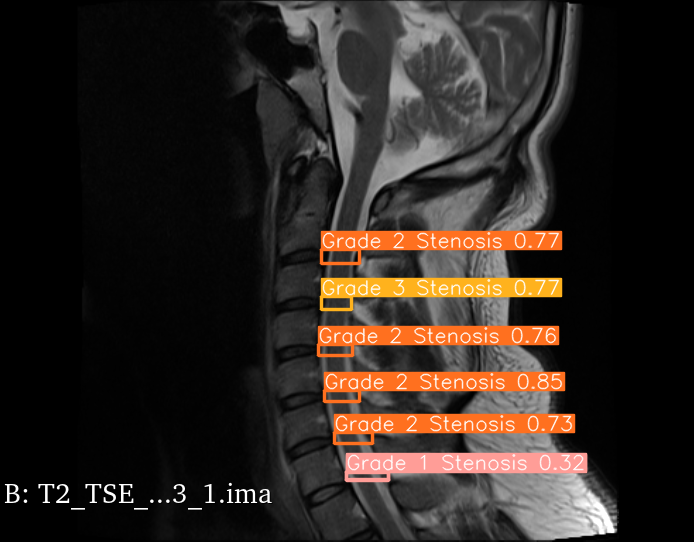

In [25]:
sample_pred.show()